<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Case-X.-Template" data-toc-modified-id="Case-X.-Template-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Case 3 Mode Template</a></span></li><li><span><a href="#Background" data-toc-modified-id="Background-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Background</a></span></li><li><span><a href="#Data-and-preprocessing" data-toc-modified-id="Data-and-preprocessing-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Data and preprocessing</a></span></li><li><span><a href="#Constructing-the-model-and-training-it" data-toc-modified-id="Constructing the model and training it-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Constructing the model and training it</a></span></li><li><span><a href="#Results-and-discussion" data-toc-modified-id="Results-and-Discussion-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Results and discussion</a></span></li><li><span><a 
href="#Conclusions" data-toc-modified-id="Conclusions-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Conclusions</a></span></li></ul></div>

# Case 3 Template
Mikko Kettunen, Niklas Koro, Sami Tanhua, Jake Pärssinen - Group 2<br>
Last edited: 19.03.2020<br>
Neural Networks for Health Technology Applications<br>
[Helsinki Metropolia University of Applied Sciences](http://www.metropolia.fi/en/)<br>

# Background
The aim of this notebook is to create a model that predicts drug ratings based on their reviews.

# Data and preprocessing

Imports

In [316]:
%pylab inline

import time # for timing
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from sklearn.model_selection import train_test_split # preprocessing datasets
from tensorflow.keras.preprocessing.text import Tokenizer # text preprocessing
from tensorflow.keras.models import Sequential # modeling neural networks
from tensorflow.keras.layers import Dense, Activation, Dropout # layers for neural networks
from sklearn.metrics import confusion_matrix, classification_report, cohen_kappa_score # final metrics

from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Embedding
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import Constant

import collections
import matplotlib.pyplot as plt
from tensorflow.keras import layers

from tensorflow.keras.preprocessing.sequence import pad_sequences # text preprocessing

Populating the interactive namespace from numpy and matplotlib


C:\Users\mikko\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['test', 'cm', 'e', 'indices']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


We downloaded the datasets and checked it by showing the first 5 rows.

In [317]:
# Show the first 5 rows
train = pd.read_csv('drugsComTrain_raw.csv')
test = pd.read_csv('drugsComTest_raw.csv')
train.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,3-Nov-15,10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37


1. We tokenized the text samples into lists of integer indices for words. We restricted the maximum number of words in the index a value of 5000, which means we are using only the 5000 most frequently occurring words in the dataset.
2. We used stop words to remove irrelevant words from the dataframe
3. The samples holds the list of strings containing the original text.
4. The sequences variable holds the corresponding integer lists after tokenization
5. Finally we printed the number of tokens found in the dataset.

In [318]:
import nltk
from nltk import word_tokenize,sent_tokenize

# Tokenize the text
samples = train['review']

stop = stopwords.words('english')
samples = samples.apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

tokenizer = Tokenizer(num_words = 5000)
tokenizer.fit_on_texts(samples)

# Convert text to sequences
sequences = tokenizer.texts_to_sequences(samples) 

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 49980 unique tokens.


Data padding was done to ensure that  all the lists are the same length.

In [319]:
data = pad_sequences(sequences, maxlen=200)

We splitted the data into 3 categories based on their ratings. The categories are:
1. Rating over 6 = category 2
2. Rating 5 or 6 = category 1
3. Rating under 5 = category 0

In [320]:
# Create three categories
labels = train['rating'].values
for i in range(len(labels)):
    x = labels[i]
    if x > 6:
        labels[i] = 2
    elif x == 5 or x == 6:
        labels[i] = 1
    else:
        labels[i] = 0

We printed the shapes of our input and output data to see if they are compatible.

In [321]:
from tensorflow.keras.utils import to_categorical

# Show data and label shapes
labels = to_categorical(np.asarray(labels))
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

Shape of data tensor: (161297, 200)
Shape of label tensor: (161297, 3)


We splitted the data into training and validation sets on a 75/25 split.

In [322]:
VALIDATION_SPLIT = 0.25

# split the data into a training set and a validation set
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
nb_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

x_train = data[:-nb_validation_samples]
y_train = labels[:-nb_validation_samples]
x_val = data[-nb_validation_samples:]
y_val = labels[-nb_validation_samples:]

# Constructing the model and training it

We then constructed the model. We used:

1. A Conv1D model with maxpooling layers between. 
2. Relu as activation function
3. Categorical_crossentropy as loss function because this is a categorial classification problem.
4. RmsProp as optimizer, because it's a good optimizer to use for almost all problems. 
5. Embedding layer was used to make the input values more connected and give the model more trainable values.

In [326]:
embedding_layer = Embedding(5000,
                            100,
                            input_length=200,
                            trainable=True)

sequence_input = Input(shape=(200,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
x = Conv1D(64, 5, activation='relu')(embedded_sequences)
x = MaxPooling1D(5)(x)
x = Conv1D(64, 5, activation='relu')(x)
x = MaxPooling1D(5)(x)
x = Conv1D(64, 5, activation='relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(64, activation='relu')(x)
preds = Dense(3, activation='softmax')(x)

model = Model(sequence_input, preds)
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

model.summary()

Model: "model_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        [(None, 200)]             0         
_________________________________________________________________
embedding_18 (Embedding)     (None, 200, 100)          500000    
_________________________________________________________________
conv1d_54 (Conv1D)           (None, 196, 64)           32064     
_________________________________________________________________
max_pooling1d_36 (MaxPooling (None, 39, 64)            0         
_________________________________________________________________
conv1d_55 (Conv1D)           (None, 35, 64)            20544     
_________________________________________________________________
max_pooling1d_37 (MaxPooling (None, 7, 64)             0         
_________________________________________________________________
conv1d_56 (Conv1D)           (None, 3, 64)             205

We chose to save the best weights on training based on validation accuracy to see if it gave us better results than just using the weights after the model had gone through all the epochs.

In [327]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Save the best weights for validation use
filepath="weights01.best.hdf5"
checkpoint = ModelCheckpoint(filepath,
                             monitor='val_acc',
                             verbose=1, 
                             save_best_only=True, mode='max')
callbacks_list = [checkpoint]

history = model.fit(x_train, y_train, 
                    epochs = 10, 
                    batch_size = 64,
                    verbose = 1,
                    validation_data = (x_val, y_val),
                    callbacks=callbacks_list)

Train on 120973 samples, validate on 40324 samples
Epoch 1/10
120960/120973 [============================>.] - ETA: 0s - loss: 0.6141 - acc: 0.7657- ETA: 0s - loss: 0.6146 - 
Epoch 00001: val_acc improved from -inf to 0.78127, saving model to weights01.best.hdf5
120973/120973 [==============================] - 176s 1ms/sample - loss: 0.6142 - acc: 0.7657 - val_loss: 0.5942 - val_acc: 0.7813
Epoch 2/10
120960/120973 [============================>.] - ETA: 0s - loss: 0.5063 - acc: 0.8116
Epoch 00002: val_acc improved from 0.78127 to 0.80649, saving model to weights01.best.hdf5
120973/120973 [==============================] - 181s 1ms/sample - loss: 0.5063 - acc: 0.8116 - val_loss: 0.5088 - val_acc: 0.8065
Epoch 3/10
120960/120973 [============================>.] - ETA: 0s - loss: 0.4241 - acc: 0.8411
Epoch 00003: val_acc improved from 0.80649 to 0.80917, saving model to weights01.best.hdf5
120973/120973 [==============================] - 185s 2ms/sample - loss: 0.4242 - acc: 0.8411 - val

# Results and discussion

We made 2 graphs to see how the validation accuracy and loss changed during the epochs. These graphs were then used to determine the right epoch number to use.

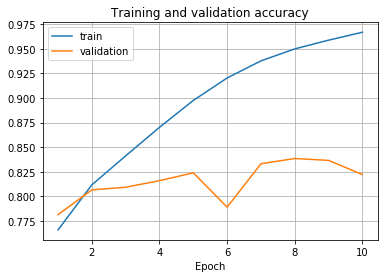

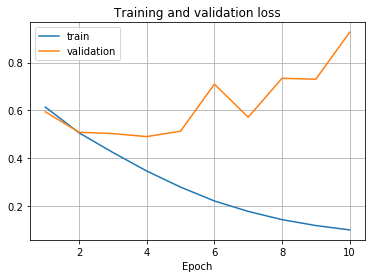

In [329]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
e = arange(len(acc)) + 1

plot(e, acc, label = 'train')
plot(e, val_acc, label = 'validation')
title('Training and validation accuracy')
xlabel('Epoch')
grid()
legend()

figure()

plot(e, loss, label = 'train')
plot(e, val_loss, label = 'validation')
title('Training and validation loss')
xlabel('Epoch')
grid()
legend()

show()


Finally we made the predictions and printed out the results, classification report, confusion matrix and cohen's kappa scores.

In [330]:
# Find the predicted values for the validation set
y_pred = argmax(model.predict(x_val), axis = 1)
y_true = argmax(y_val, axis = 1)

In [331]:
# Calculate the classification report
cr = classification_report(y_true, y_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.76      0.80      0.78      9927
           1       0.41      0.57      0.48      3571
           2       0.93      0.86      0.90     26826

    accuracy                           0.82     40324
   macro avg       0.70      0.74      0.72     40324
weighted avg       0.84      0.82      0.83     40324



In [332]:
# Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred).T
print(cm)

[[ 7913   772  1659]
 [  990  2033  1963]
 [ 1024   766 23204]]


In [333]:
# Calculate the cohen's kappa, both with linear and quadratic weights
k = cohen_kappa_score(y_true, y_pred)
print(f"Cohen's kappa (linear)    = {k:.3f}")
k2 = cohen_kappa_score(y_true, y_pred, weights = 'quadratic')
print(f"Cohen's kappa (quadratic) = {k2:.3f}")

Cohen's kappa (linear)    = 0.654
Cohen's kappa (quadratic) = 0.745


We changed the numpy arrays to dataframes to make them compatible for merging.

In [334]:
y_true2 = pd.DataFrame(y_true)

In [335]:
y_pred2 = pd.DataFrame(y_pred)

We merged the observed, predicted and residual values to show how our model predicted certain cases.

In [336]:
# merge observed and predicted values and compute residuals
df2 = pd.concat([y_true2, y_pred2, y_true2-y_pred2], axis=1)
df2.columns=['observed','predicted','residual']
print(df2)

       observed  predicted  residual
0             0          0         0
1             1          0         1
2             0          0         0
3             2          2         0
4             2          2         0
...         ...        ...       ...
40319         2          2         0
40320         2          2         0
40321         0          0         0
40322         2          0         2
40323         2          2         0

[40324 rows x 3 columns]


We loaded the best weights based on validation accuracy to see if the results were better than with the weights taken after full training.

In [337]:
# Load best weights from training
model.load_weights("weights01.best.hdf5")

In [338]:
# Compile the model again
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])


In [339]:
# Find the predicted values for the validation set
y_pred = argmax(model.predict(x_val), axis = 1)
y_true = argmax(y_val, axis = 1)

In [340]:
# Calculate the classification report
cr = classification_report(y_true, y_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.85      0.70      0.77      9927
           1       0.51      0.35      0.42      3571
           2       0.86      0.96      0.91     26826

    accuracy                           0.84     40324
   macro avg       0.74      0.67      0.70     40324
weighted avg       0.83      0.84      0.83     40324



In [341]:
# Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred).T
print(cm)

[[ 6910   479   721]
 [  720  1256   463]
 [ 2297  1836 25642]]


In [342]:
# Calculate the cohen's kappa, both with linear and quadratic weights
k = cohen_kappa_score(y_true, y_pred)
print(f"Cohen's kappa (linear)    = {k:.3f}")
k2 = cohen_kappa_score(y_true, y_pred, weights = 'quadratic')
print(f"Cohen's kappa (quadratic) = {k2:.3f}")

Cohen's kappa (linear)    = 0.644
Cohen's kappa (quadratic) = 0.724


# Conclusions

### Simple Neural Network.
First we tested predicting the values with a simple model that had only three fully connected neural layers. <br> 
The model did suprisingly well. <br>
The F1-scores for each class were:

0       0.81 <br>
1       0.57 <br>
2       0.92 <br>

 
The biggest problem with this model was overfitting. <BR>
We tried dropout and other measures but the model allways overfitted after 4 epocs. 
We didn't use this as our final model, because the assignment was to use either Conv1D or RNN model.
### LSTM
We brifly tested LSTM and RNN structures on the model but the result were poor. <br>
Also some articles idicated that this method maybe wasn't the best way to solve this kind of problem. <br>
https://towardsdatascience.com/recurrent-neural-networks-by-example-in-python-ffd204f99470 <br>
### Conv1D
Our final model was a Conv1D model.
From the start this model gave good prediction accuracy values. <br>
We tried to increase the accuracy with the following steps: <br>
1. Batch size. The tested batch sizes were 128, 32 and 64.<br> There were no big differences but the model with 64 batch size was a little bit better. <br>
2. Conv1D filter amount. The tested filter values were 128, 32 and 64. The filter value of 64 was overall the best because using 128 would make the model unneccesary complex. <br>
3. Maxpooling1D size. We tried 3 and 5.Pooling size of 5 gave better accuracy. <br>
4. Dropout. Using dropout on this model did not help with the overfitting. <br>
5. Recording the weights that gave the best validation accuracy during the training and then using them in the testing did not improve the accuracy significantly <br>

### Final accuracy of the Conv1D model


    precision    recall  f1-score   support

           0       0.85      0.70      0.77      9927
           1       0.51      0.35      0.42      3571
           2       0.86      0.96      0.91     26826

    accuracy                           0.84     40324
    
 
#### Cohen's Kappa values

Cohen's kappa (linear)    = 0.644<br>
Cohen's kappa (quadratic) = 0.724<br>

There was a difficulty to predict the accuracy on output value 1 on all models. This might be because this output values consist of only to rating values. 